# Clusterização da MEIP por Zona OD, considerando ou não a vizinhança

O método proposto vai clusterizar por k-medioides e de maneira hierarquica, primeiramente sem considerar a vizinhança e depois comparando com duas propostas. A primeira adicionando às dimensões, um índice local de Moran para cada dimensão e a outra considerando apenas essa nova dimensão calculada.

Para avaliar os resultados propomos a aplicação do método SHAP para compreender os agrupamentos e a relevância de cada dimensão para cada estratégia utilizada

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
df_meip = pd.read_csv('data/df_meip_v_02.csv', sep=';', decimal=',')\
    .set_index('od_id')

In [3]:
gdf_od = gpd.read_file('data/zonas-OD-2017-São-Paulo.gpkg')

## Dimensões

In [4]:
import seaborn as sns

In [5]:
# demanda = [
#     "prod_desl_pe",astype('int64')
#     "atra_desl_pe",
# ]

# sinistros = [
#     "atrop_tot",
#     "atrop_fer",
#     "atrop_fat",
#     "fatalid"
# ]

# faixas_pedestre = [
#     "faixas_detectadas",
#     "demanda_faixas",
#     "prop_atendida"
# ]

modelo = [
    "ren_median_f",
    "sin_tot",
    "p_atrop_sin",
    "fatalid",
    "atrop_desl",
    "p_atrop_esc",
    "p_atrop_auto",
    "p_atrop_moto",
    "p_atrop_onibus",
    "p_atrop_caminh",
    "p_atrop_bicicl",
    "p_atrop_tr_mo",
    "p_atrop_pri",
    "p_atrop_sec_ter",
    "p_atrop_loc",
    "p_atrop_ati",
    "p_atrop_rur",
    "p_atrop_rap",
    "p_atrop_len",
    "CA_medio",
    "p_n_resid",
    "p_fam_n_motor",
    "p_fx_ped_at",
    "med_calc",
    "dens_ilumi",
    "inters_crit",
    "dem_sem_at_osm",
    "w_CMA_15",
    "w_CMP_15",
    "b_CMA_30",
    "b_CMP_30",
    "pt_CMA_60",
    "pt_CMP_60",
    "c_CMA_60",
    "c_CMP_60",
    "c_CMAS_15",
]

In [6]:
df_meip.columns

Index(['nome_od', 'area_ha', 'distrito', 'subpref', 'RA_5', 'RA_8',
       'ren_med_f', 'ren_median_f', 'ren_per_cap', 'p_pop_n_alfab',
       'p_pop_fund_I_II', 'p_pop_medio', 'p_pop_superior', 'sin_tot',
       'atrop_tot', 'p_atrop_sin', 'atrop_fer', 'atrop_fat', 'fatalid',
       'atrop_desl', 'atrop_escuro', 'p_atrop_esc', 'p_atrop_auto',
       'p_atrop_moto', 'p_atrop_onibus', 'p_atrop_caminh', 'p_atrop_bicicl',
       'p_atrop_outros', 'p_atrop_tr_mo', 'p_atrop_pri', 'p_atrop_sec_ter',
       'p_atrop_loc', 'p_atrop_ati', 'p_atrop_rur', 'p_atrop_rap',
       'p_atrop_len', 'ext_viario_km_osm', 'ext_tr_mo', 'ext_pri',
       'ext_sec_ter', 'ext_loc', 'ext_ati', 'ext_rur', 'p_ext_tr_mo',
       'p_ext_pri', 'p_ext_sec_ter', 'p_ext_local', 'p_ext_ativo',
       'p_ext_rural', 'ind_via_eq', 'CA_medio', 'p_comercial', 'p_out_usos',
       'p_n_resid', 'desl_pe', 'p_fam_n_motor', 'p_fx_ped_at', 'med_calc',
       'dens_ilumi', 'inters_crit', 'dem_sem_at_osm', 'ptos_alcool',
       'w

In [7]:
df_meip[modelo].dtypes

ren_median_f        object
sin_tot              int64
p_atrop_sin        float64
fatalid            float64
atrop_desl         float64
p_atrop_esc        float64
p_atrop_auto       float64
p_atrop_moto       float64
p_atrop_onibus     float64
p_atrop_caminh     float64
p_atrop_bicicl     float64
p_atrop_tr_mo      float64
p_atrop_pri        float64
p_atrop_sec_ter    float64
p_atrop_loc        float64
p_atrop_ati        float64
p_atrop_rur        float64
p_atrop_rap        float64
p_atrop_len        float64
CA_medio           float64
p_n_resid          float64
p_fam_n_motor      float64
p_fx_ped_at        float64
med_calc           float64
dens_ilumi         float64
inters_crit          int64
dem_sem_at_osm      object
w_CMA_15             int64
w_CMP_15             int64
b_CMA_30             int64
b_CMP_30             int64
pt_CMA_60            int64
pt_CMP_60            int64
c_CMA_60             int64
c_CMP_60             int64
c_CMAS_15            int64
dtype: object

In [8]:
for a in modelo:
    if df_meip[a].dtype == 'object': 
        df_meip[a] = pd.to_numeric(df_meip[a], errors='coerce').fillna(0)
        print(a)
        print(df_meip[a].isna().value_counts())

ren_median_f
False    342
Name: ren_median_f, dtype: int64
dem_sem_at_osm
False    342
Name: dem_sem_at_osm, dtype: int64


In [9]:
df_meip.fillna(0, inplace=True)

<AxesSubplot: >

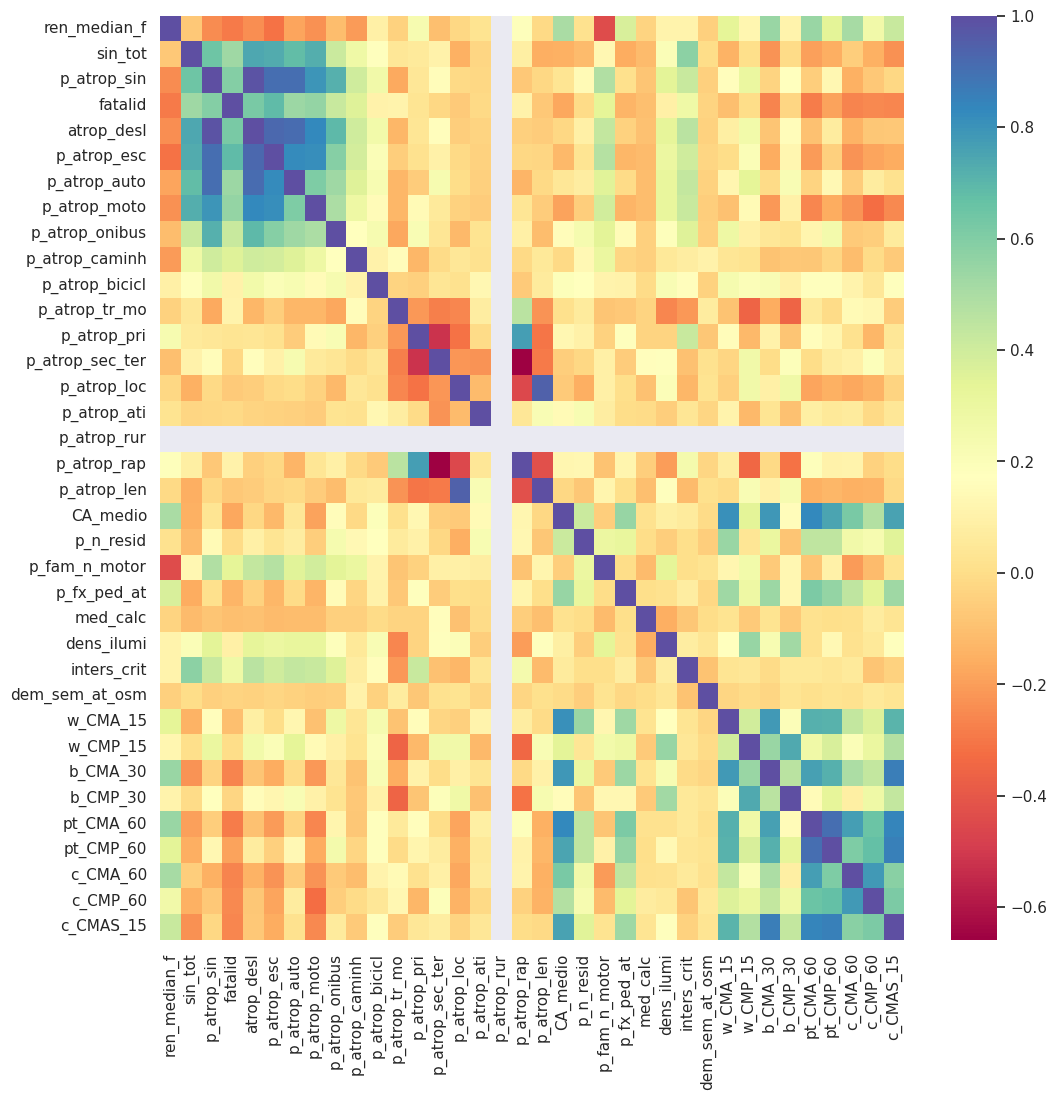

In [10]:
sns.set(rc={"figure.figsize":(12, 12)})
correlacao_modelo = df_meip[modelo].corr()
sns.heatmap(correlacao_modelo, cmap="Spectral", annot=False)

In [11]:
# sns.pairplot(df_meip[modelo])

## K-Clusterização

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline 

In [13]:
n_clusters = 5

In [14]:
scaler = MinMaxScaler((-1,1))
# scaler = StandardScaler()

In [15]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaler.fit_transform(df_meip[modelo]))
    # kmeanModel.fit(scaler.fit_transform(df_meip))
    distortions.append(kmeanModel.inertia_)

In [16]:
sns.set(rc={"figure.figsize":(10, 10)})

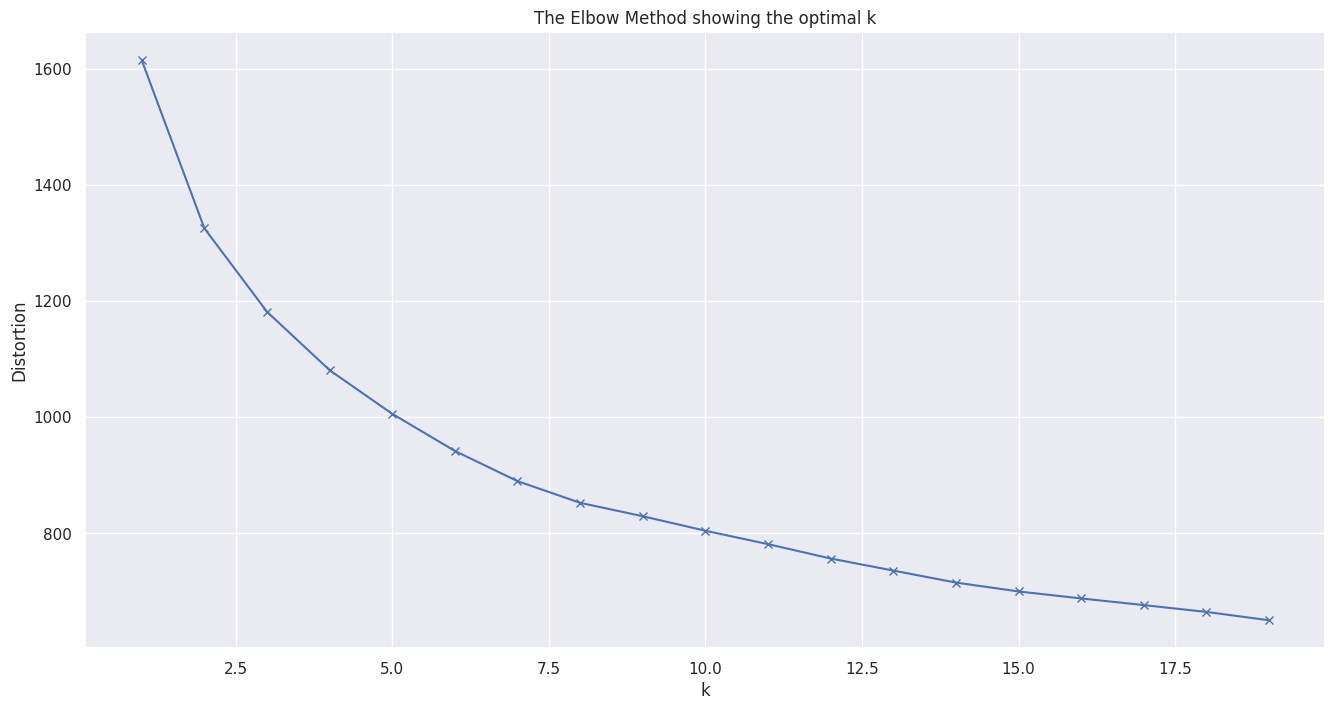

In [17]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<AxesSubplot: >

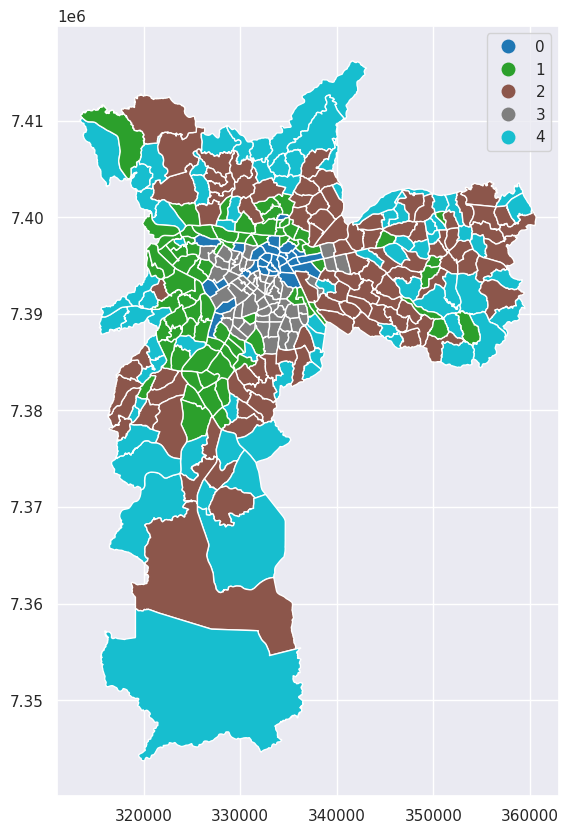

In [19]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.fit_transform(df_meip[modelo]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True, categorical=True)

In [20]:
df_meip.loc[:, modelo + ['k_cluster']].groupby('k_cluster').median().style.background_gradient()

,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,p_atrop_bicicl,p_atrop_tr_mo,p_atrop_pri,p_atrop_sec_ter,p_atrop_loc,p_atrop_ati,p_atrop_rur,p_atrop_rap,p_atrop_len,CA_medio,p_n_resid,p_fam_n_motor,p_fx_ped_at,med_calc,dens_ilumi,inters_crit,dem_sem_at_osm,w_CMA_15,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15
k_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3450.000000,162.000000,35.360000,2.820000,15.000000,14.945000,21.410000,7.405000,6.170000,0.995000,0.000000,3.795000,23.690000,33.630000,22.280000,1.260000,0.000000,36.015000,23.365000,5.690000,57.305000,60.255000,24.415000,3.130000,25.060000,490.500000,0.000000,20787.500000,11039.500000,226076.000000,176821.500000,2423140.000000,3329209.500000,4857815.000000,9402174.000000,91.000000
1,4209.000000,159.000000,13.120000,2.170000,6.000000,8.450000,10.280000,5.240000,1.730000,0.000000,0.000000,11.900000,35.480000,22.540000,17.390000,0.000000,0.000000,52.110000,19.350000,3.070000,14.850000,31.030000,13.300000,2.430000,23.300000,480.000000,0.000000,5128.000000,6088.000000,84061.000000,141324.000000,1466873.000000,1802290.000000,4699106.000000,8417470.000000,48.000000
2,2817.000000,263.500000,34.150000,3.755000,15.500000,17.995000,22.065000,12.095000,4.040000,0.940000,0.000000,0.000000,9.135000,49.735000,28.175000,0.000000,0.000000,15.645000,28.970000,1.180000,13.340000,44.690000,9.200000,2.020000,30.280000,551.000000,0.000000,4379.500000,13446.500000,89116.000000,285262.500000,754253.000000,1433826.500000,3873340.500000,8162191.500000,43.000000
3,6000.000000,83.000000,14.815000,1.175000,5.500000,5.960000,11.660000,3.670000,1.470000,0.000000,0.000000,0.000000,7.945000,38.800000,38.675000,0.000000,0.000000,14.420000,41.455000,5.380000,19.380000,28.400000,20.625000,3.055000,25.960000,301.000000,0.000000,12270.500000,16283.500000,314899.500000,311719.500000,1963305.500000,2416234.000000,4867744.500000,8964408.000000,98.500000
4,2453.000000,111.000000,15.900000,2.170000,7.000000,8.980000,11.240000,5.740000,1.470000,0.000000,0.000000,0.000000,0.000000,30.770000,42.310000,0.000000,0.000000,16.000000,46.510000,0.940000,14.080000,47.030000,5.260000,2.100000,25.970000,216.000000,0.000000,2413.000000,7700.000000,44921.000000,147210.000000,423173.000000,837374.000000,3440776.000000,7389030.000000,22.000000


## Clusterização hierarquica

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

In [22]:
# Z = linkage(df_meip[modelo], 'centroid')
Z = linkage(scaler.fit_transform(df_meip[modelo]), 'ward')

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [12.5, 12.5, 40.0, 40.0]],
 'dcoord': [[0.0, 12.639607695460109, 12.639607695460109, 0.0],
  [0.0, 13.312414919832888, 13.312414919832888, 12.639607695460109],
  [0.0, 15.904469118778229, 15.904469118778229, 0.0],
  [13.312414919832888,
   21.878083850941962,
   21.878083850941962,
   15.904469118778229]],
 'ivl': ['(59)', '(43)', '(66)', '(73)', '(101)'],
 'leaves': [678, 669, 674, 676, 677],
 'color_list': ['C1', 'C1', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C0', 'C0']}

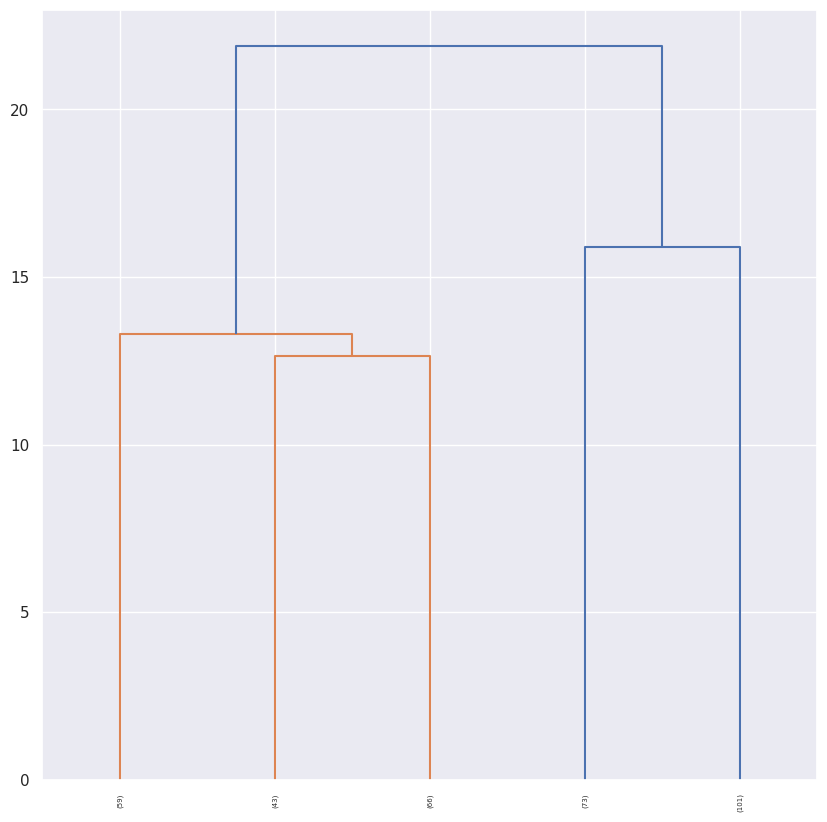

In [23]:
dendrogram(Z, leaf_rotation=90, leaf_font_size=n_clusters, labels=df_meip.index, truncate_mode = 'lastp', p=n_clusters, show_leaf_counts=True)
# dendrogram(Z, leaf_rotation=90, leaf_font_size=6)

In [24]:
df_meip['h_cluster'] = fcluster(Z, t=n_clusters, criterion='maxclust')

In [25]:
np.unique(fcluster(Z, t=n_clusters, criterion='maxclust'), return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([ 59,  43,  66,  73, 101]))

In [26]:
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')

In [56]:
taxonomia = {
    4:4, #"centro",
    0:1, #"centro sudoeste",
    3:5, #"cinturão das marginais",
    1:3, #"periferia",
    2:0, #"transição periférica",
}

<AxesSubplot: >

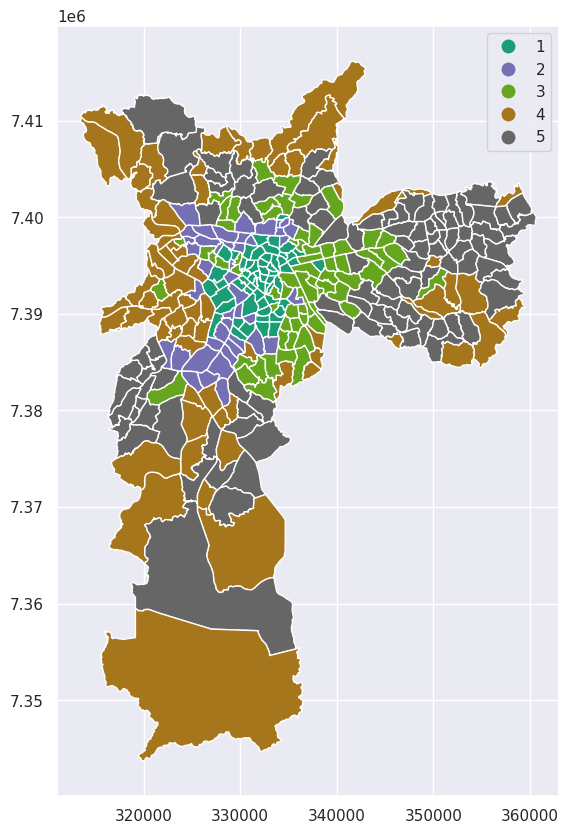

In [58]:
gdf_zona_merged.plot(column='h_cluster', legend=True, categorical=True, cmap='Dark2')

## Matriz de vizinhança

In [28]:
import libpysal as lps

In [29]:
wq = lps.weights.Queen.from_dataframe(gdf_od)

In [30]:
wq.transform = 'r'

In [31]:
for m in modelo:
    df_meip[f'{m}_vizinhos'] = lps.weights.lag_spatial(wq, df_meip[m])

In [32]:
modelo_vizinhanca = modelo + [m + "_vizinhos" for m in modelo]

## Clusterização K+LISA+Means (-constrain | +affinity)

Achar uma agulha no palheiro difere de encontrar um palheiro cheio de agulhas espalhadas de forma homogênea

In [33]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
    # kmeanModel.fit(scaler.fit_transform(df_meip))
    distortions.append(kmeanModel.inertia_)

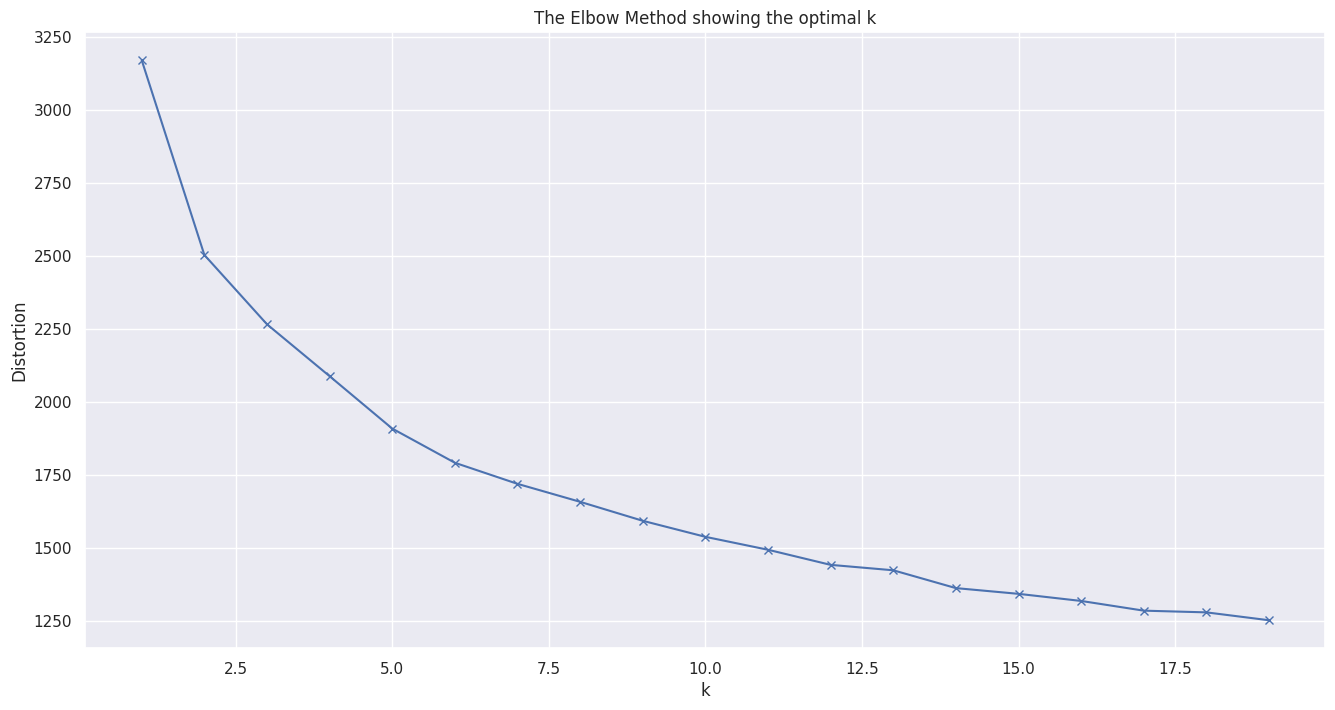

In [34]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
# extrema periferia
# média periferia
# centro
# centro sudoeste
# cinturão das marginais

In [36]:
taxonomia = {
    0:"centro sudoeste",
    1:"extrema periferia",
    2:"média periferia",
    3:"cinturão das marginais",
    4:"centro",
}

In [37]:
taxonomia.values()

dict_values(['centro sudoeste', 'extrema periferia', 'média periferia', 'cinturão das marginais', 'centro'])

In [38]:
df_meip.k_cluster.dtype

dtype('int32')

<AxesSubplot: >

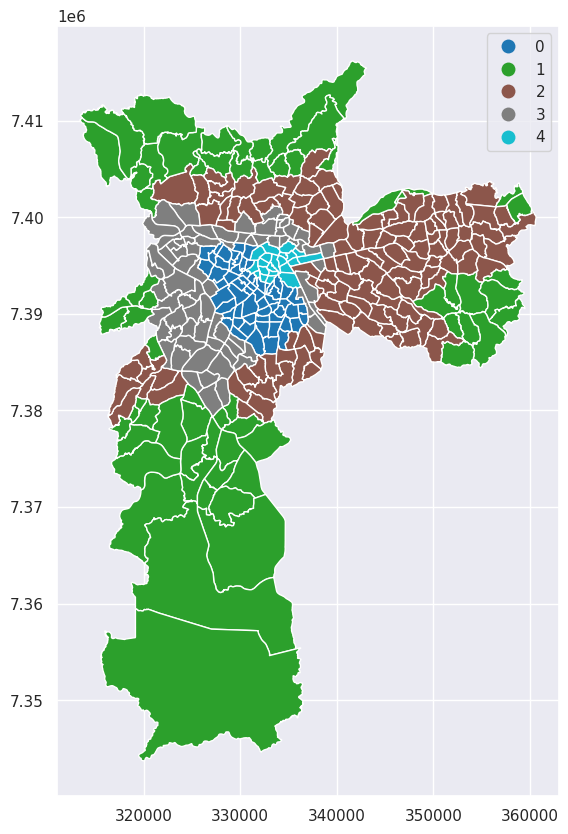

In [39]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True, categorical=True)

In [40]:
df_meip.loc[:, modelo + ['k_cluster']].groupby('k_cluster').quantile(.50).style.background_gradient()

,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,p_atrop_bicicl,p_atrop_tr_mo,p_atrop_pri,p_atrop_sec_ter,p_atrop_loc,p_atrop_ati,p_atrop_rur,p_atrop_rap,p_atrop_len,CA_medio,p_n_resid,p_fam_n_motor,p_fx_ped_at,med_calc,dens_ilumi,inters_crit,dem_sem_at_osm,w_CMA_15,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15
k_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6143.000000,82.000000,14.340000,1.300000,5.000000,5.420000,11.660000,3.620000,1.490000,0.000000,0.000000,0.000000,14.290000,33.330000,36.000000,0.000000,0.000000,17.140000,36.670000,5.530000,19.680000,26.500000,20.800000,3.070000,25.210000,326.000000,0.000000,12010.000000,15740.000000,311999.000000,309762.000000,1986184.000000,2400110.000000,4865763.000000,8918022.000000,98.000000
1,2453.000000,138.000000,18.430000,3.020000,8.000000,10.540000,11.940000,7.180000,2.070000,0.590000,0.000000,0.000000,6.850000,27.270000,36.000000,0.000000,0.000000,25.710000,39.440000,0.720000,13.320000,48.240000,4.310000,2.070000,24.640000,251.000000,0.000000,1744.000000,5413.000000,31733.000000,102108.000000,276365.000000,600573.000000,2791141.000000,6467843.000000,16.000000
2,2926.500000,209.000000,28.750000,3.125000,13.000000,14.735000,18.590000,8.670000,2.730000,0.575000,0.000000,0.000000,5.825000,47.380000,30.670000,0.000000,0.000000,15.690000,32.110000,1.370000,14.750000,44.005000,9.200000,2.045000,30.160000,412.500000,0.000000,4397.000000,13895.000000,91960.500000,293165.500000,800105.000000,1527765.500000,4032750.000000,8510800.500000,48.000000
3,4500.000000,163.000000,13.850000,2.170000,6.000000,8.690000,11.170000,5.240000,1.750000,0.000000,0.000000,15.790000,28.570000,23.910000,19.570000,0.000000,0.000000,46.300000,22.730000,3.430000,16.230000,33.100000,14.420000,2.500000,22.180000,480.000000,0.000000,5218.000000,6285.000000,84061.000000,117193.000000,1493188.000000,1822632.000000,4746415.000000,8588398.000000,49.000000
4,3044.000000,145.000000,37.080000,2.480000,15.000000,15.400000,21.610000,7.690000,5.130000,0.650000,0.430000,5.060000,12.000000,46.580000,22.090000,1.160000,0.000000,26.740000,23.400000,6.830000,56.080000,63.970000,27.780000,3.130000,27.760000,325.000000,0.000000,20528.000000,12493.000000,249275.000000,213111.000000,2511222.000000,3593945.000000,4887362.000000,9475393.000000,104.000000


In [41]:
for k in kmeans.labels_:
    df_meip.loc[df_meip['k_cluster'] == k, modelo + ['k_cluster']].describe()

In [42]:
df_meip.loc[df_meip['k_cluster'] == 2, modelo + ['k_cluster']].describe()

,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,...,w_CMA_15,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15,k_cluster
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.000000,122.000000,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,122.000000,122.0
mean,2967.975410,222.926230,28.930410,3.337951,12.959016,15.249590,19.939836,9.530164,3.487049,0.713443,...,4578.524590,13757.188525,93322.262295,297297.450820,8.547073e+05,1.575295e+06,3.767765e+06,8.341387e+06,46.934426,2.0
std,836.244067,106.034858,12.006437,1.799464,5.865430,6.584903,7.462599,5.268368,2.411952,0.748087,...,1725.922899,3891.634338,26701.906279,94561.504456,3.672665e+05,4.933388e+05,8.829266e+05,9.910880e+05,14.098085,0.0
min,0.000000,45.000000,6.320000,0.000000,3.000000,3.030000,4.410000,0.000000,0.000000,0.000000,...,192.000000,1319.000000,20885.000000,84114.000000,2.599480e+05,7.581840e+05,1.217278e+06,5.148563e+06,11.000000,2.0
25%,2465.500000,140.250000,20.497500,2.172500,9.000000,10.097500,14.615000,5.897500,1.730000,0.000000,...,3739.250000,11744.500000,73875.000000,228658.250000,5.674085e+05,1.220217e+06,3.122068e+06,7.962424e+06,38.000000,2.0
50%,2926.500000,209.000000,28.750000,3.125000,13.000000,14.735000,18.590000,8.670000,2.730000,0.575000,...,4397.000000,13895.000000,91960.500000,293165.500000,8.001050e+05,1.527766e+06,4.032750e+06,8.510800e+06,48.000000,2.0
75%,3213.000000,286.000000,35.915000,4.317500,16.000000,19.385000,25.890000,12.320000,4.705000,1.050000,...,5060.000000,16093.500000,113179.750000,358051.750000,1.115655e+06,1.851350e+06,4.517668e+06,9.028419e+06,55.000000,2.0
max,5700.000000,547.000000,63.200000,10.180000,30.000000,37.390000,39.900000,25.810000,13.850000,4.580000,...,14447.000000,23275.000000,154841.000000,504375.000000,1.886891e+06,3.171483e+06,4.816365e+06,9.830701e+06,77.000000,2.0


## Clusterização somente da vizinhança

In [54]:
taxonomia = {
    4:4, #"centro",
    0:1, #"centro sudoeste",
    3:5, #"cinturão das marginais",
    1:3, #"periferia",
    2:0, #"transição periférica",
}

<AxesSubplot: >

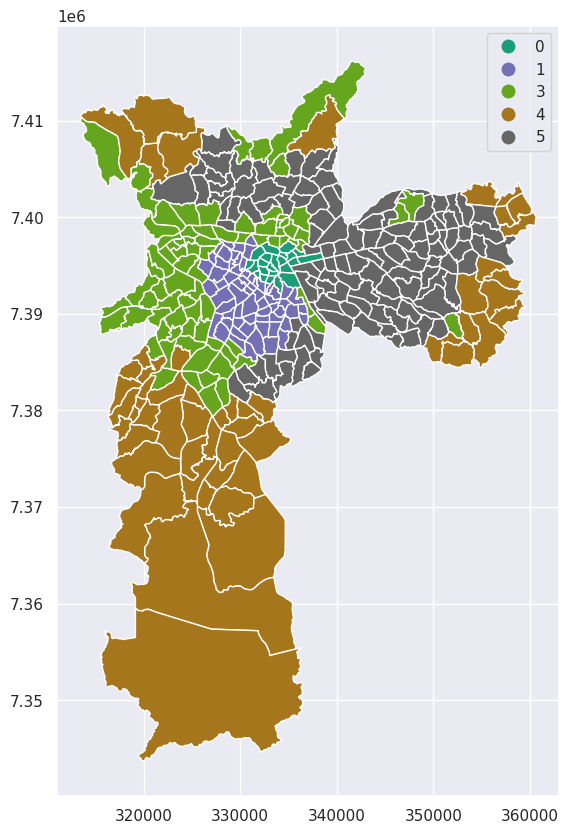

In [55]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.fit_transform(df_meip[[m + "_vizinhos" for m in modelo]]))
df_meip['k_cluster'] = kmeans.labels_
df_meip['k_labels'] = [taxonomia[k] for k in kmeans.labels_]
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_labels', legend=True, categorical=True, cmap='Dark2')

## Neighbor Weighted K-Clusterization

In [44]:
for m in modelo:
    df_meip[f'{m}_weighted'] = lps.weights.lag_spatial(wq, df_meip[m]) * df_meip[f'{m}']

# lps.weights.lag_spatial(wq, df_meip[modelo[0]])

<AxesSubplot: >

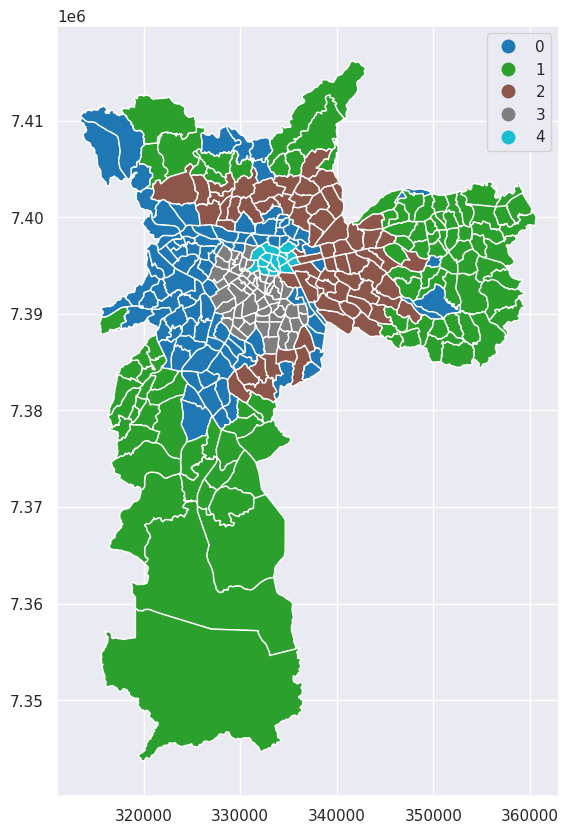

In [49]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.fit_transform(df_meip[[m + "_weighted" for m in modelo]]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True, categorical=True)

<AxesSubplot: >

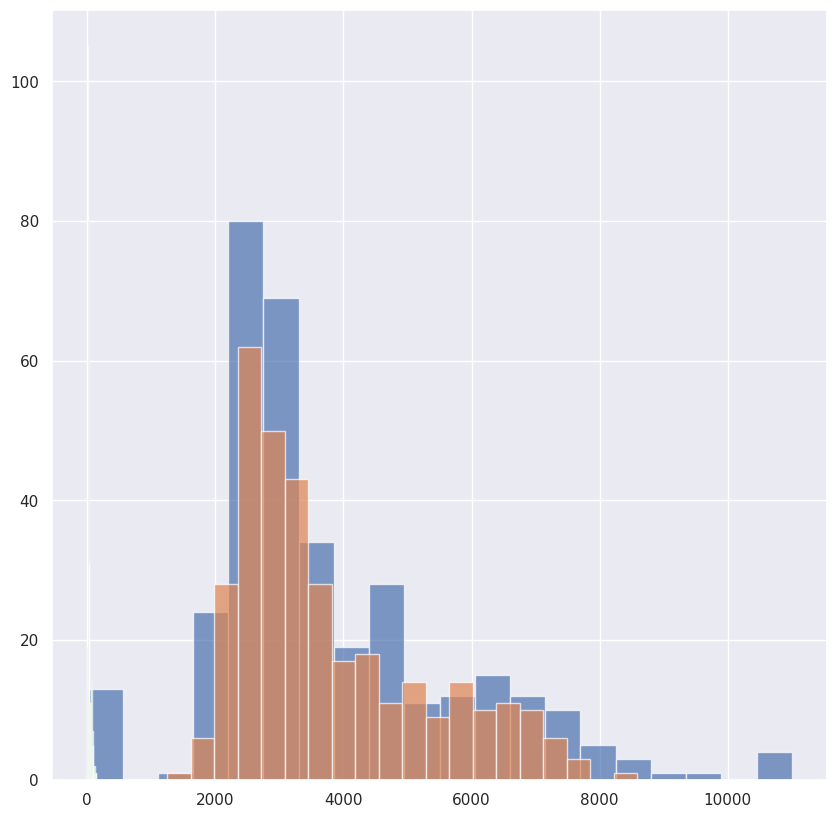

In [46]:
# scaler_dim = MinMaxScaler((0,1))
# (pd.Series(lps.weights.lag_spatial(wq, df_meip[modelo[0]])) * df_meip[modelo[0]]).fillna(0.)
(df_meip[modelo[0]]).hist(bins=20, alpha=0.7)
pd.Series(lps.weights.lag_spatial(wq, df_meip[modelo[0]])).hist(bins=20, alpha=0.7)
((pd.Series(lps.weights.lag_spatial(wq, df_meip[modelo[0]])) * df_meip[modelo[0]])/600000).hist(bins=20, alpha=0.7)

In [47]:
df_meip[modelo]

,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,...,dem_sem_at_osm,w_CMA_15,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15
od_id,,,,,,,,,,,,,,,,,,,,,
1,2884.0,82,35.01,4.38,12.0,10.40,16.98,7.12,8.21,0.55,...,0.0,51902,8412,326070,322614,2827486,4751040,4916564,9482760,135
2,2884.0,192,89.34,6.49,36.0,32.04,43.30,22.51,12.12,2.60,...,0.0,24162,8529,249275,186741,2727042,4374176,4893213,9599468,104
3,3400.0,145,41.18,5.64,17.0,21.03,25.65,7.69,5.13,1.03,...,0.0,21047,15419,308796,280541,2588406,4151365,4918093,9604328,134
4,3580.0,334,47.94,5.76,23.0,29.77,29.29,13.44,4.80,0.96,...,0.0,24079,22271,386397,284921,2556444,3593945,4936969,9360592,163
5,3500.0,174,60.25,6.10,24.0,26.29,29.10,12.67,15.96,0.47,...,0.0,57766,22866,357869,352376,2719970,4199340,4904843,9173656,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2600.0,331,21.43,1.15,10.0,12.70,19.05,9.24,0.58,0.00,...,0.0,3091,4837,22278,41920,889361,652865,4645056,7870827,18
339,0.0,85,5.18,1.00,2.0,6.00,6.00,2.00,1.00,0.00,...,0.0,1336,1195,26731,31687,1252847,1036486,4599025,7624696,35
340,6000.0,288,17.48,1.84,9.0,9.80,9.80,9.80,4.90,0.00,...,0.0,5218,2660,57359,43629,2050047,2195487,4687102,7877937,60
